In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

from process import load_trace, METRICS_CONFIGS
sns.set_theme()

In [3]:
anomaly = "LFBT_LFBL"
metrics_config = 0
ANOMALY_NAME = "STSB"

In [4]:
normal_df, _ = load_trace(anomaly, "xFTx.xx", metrics_config)
stress_df, _ = load_trace(anomaly, "SFTS.xx", metrics_config)

In [5]:
stress_df

,TIMESTAMP,DURATION,L1D_CACHE,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB,CONTEXT
1,3113544595,193,1450,36,48,228,141,130,STSB
2,3113544796,336,3895,31,29,273,168,156,STSB
3,3113545144,87,1446,36,42,297,41,56,STSB
4,3113545240,375,9799,38,45,217,95,94,STSB
5,3113545624,63,580,14,14,77,36,36,STSB
...,...,...,...,...,...,...,...,...,...
10498,9732476054,54839,2196712,468,1228,3956,1957,1968,STSB
10499,9732530924,55307,2197549,608,1378,4663,2219,2286,STSB
10500,9732586263,54390,2192938,346,1182,3433,1568,1607,STSB
10501,9732640690,54854,2196722,491,1262,4056,1864,1901,STSB


In [6]:
normal_df = (
    normal_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(normal_df.index // 25).mean()
)
normal_df.insert(
    len(normal_df.axes), "CONTEXT", ["NOSTRESS" for _ in range(len(normal_df))]
)
stress_df = (
    stress_df[['DURATION'] + METRICS_CONFIGS[metrics_config]].groupby(stress_df.index // 25).mean()
)
stress_df.insert(
    len(stress_df.axes), "CONTEXT", [ANOMALY_NAME for _ in range(len(stress_df))]
)


In [7]:
normal_df

,DURATION,L1D_CACHE,CONTEXT,L1D_CACHE_REFILL,L1D_CACHE_WB,L2D_CACHE,L2D_CACHE_REFILL,L2D_CACHE_WB
0,42230.758333,1.719269e+06,NOSTRESS,438.512500,1072.700000,3406.841667,62.966667,59.012500
1,43111.108333,1.751025e+06,NOSTRESS,379.220833,956.725000,2983.395833,54.595833,73.133333
2,43252.862500,1.755485e+06,NOSTRESS,378.112500,959.562500,3003.850000,97.925000,48.466667
3,43387.125000,1.760528e+06,NOSTRESS,380.600000,969.350000,3050.075000,116.600000,54.825000
4,43501.829167,1.765180e+06,NOSTRESS,388.325000,969.895833,3051.383333,105.591667,50.383333
...,...,...,...,...,...,...,...,...
416,53800.475000,2.180599e+06,NOSTRESS,445.770833,1098.404167,3549.529167,102.845833,54.825000
417,53158.154167,2.155203e+06,NOSTRESS,433.562500,1087.954167,3511.266667,106.516667,54.454167
418,43092.532000,1.756933e+06,NOSTRESS,399.960000,1024.528000,3151.248000,99.092000,50.080000
419,48094.295833,1.948551e+06,NOSTRESS,399.841667,985.429167,3184.216667,107.520833,47.120833


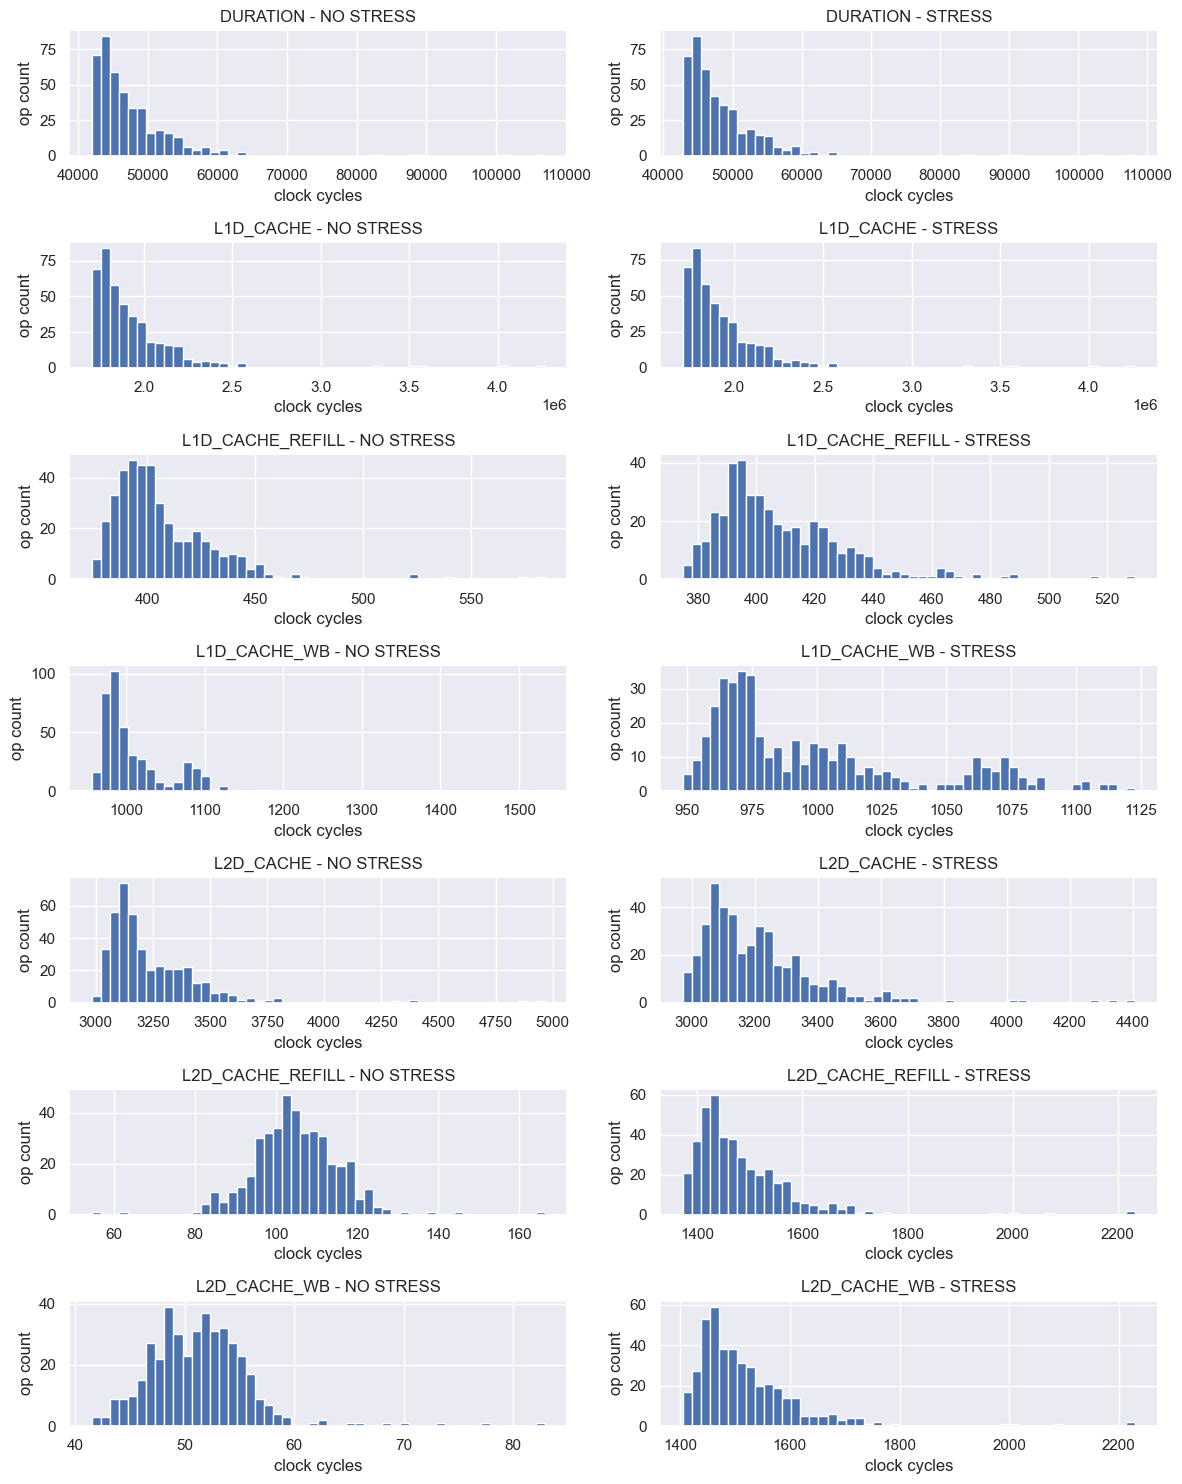

In [8]:
fig, axs = plt.subplots(7, 2, figsize=(12, 15))
for i, o in enumerate(['DURATION'] + METRICS_CONFIGS[metrics_config]):
    no_st_ax, st_ax = axs[i][0], axs[i][1]
    no_st_ax.set_title(f"{o} - NO STRESS")
    no_st_ax.set_xlabel("clock cycles")
    no_st_ax.set_ylabel("op count")
    st_ax.set_title(f"{o} - STRESS")
    st_ax.set_xlabel("clock cycles")
    st_ax.set_ylabel("op count")
    normal_df[o].hist(bins=50, ax=no_st_ax)
    stress_df[o].hist(bins=50, ax=st_ax)

plt.tight_layout()
plt.show()


In [9]:
predictors = ['L1D_CACHE_REFILL', 'L2D_CACHE_REFILL', 'L2D_CACHE_WB']

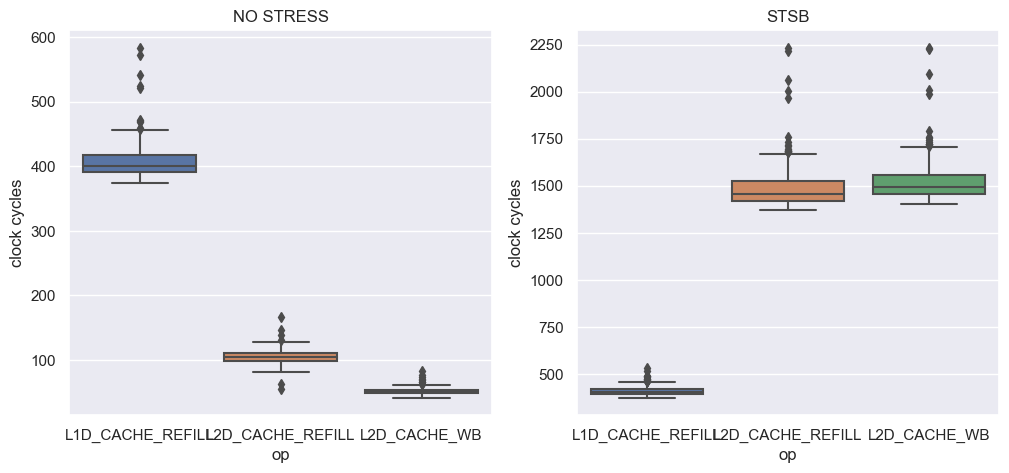

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [11]:
def drop_quantile(df, q=0.025):
    cols = predictors  # one or more

    Q1 = df[cols].quantile(q)
    Q3 = df[cols].quantile(1 - q)
    IQR = Q3 - Q1

    df = df[
        ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    ]
    return df


In [12]:
normal_df = drop_quantile(normal_df)
stress_df = drop_quantile(stress_df)
merged = pd.concat([normal_df, stress_df])
model = KMeans(n_clusters=2)
model.fit(merged[predictors])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [13]:
labels = {"NOSTRESS": 0, ANOMALY_NAME: 1}


def test_fn(test_df, model):
    results = model.predict(test_df[predictors])
    y_true = test_df["CONTEXT"].to_numpy()
    y_true = [labels[y] for y in y_true]
    y_pred = results
    print(
        "Accuracy in regime prediction:",
        f"{round(accuracy_score(y_true, y_pred) * 100, 2)}%",
    )


In [14]:
test_fn(merged, model)

Accuracy in regime prediction: 100.0%


# Test ZTFZ.ZZ: intermittent anomaly

In [15]:
test_df, _ = load_trace(anomaly, "ZFTZ.ZZ", metrics_config)
test_df = test_df.reset_index(drop=True)
y_true = test_df["CONTEXT"].iloc[::25]
y_true = y_true.reset_index(drop=True)
test_df = test_df[METRICS_CONFIGS[metrics_config]].groupby(test_df.index // 25).mean()
test_df["CONTEXT"] = y_true


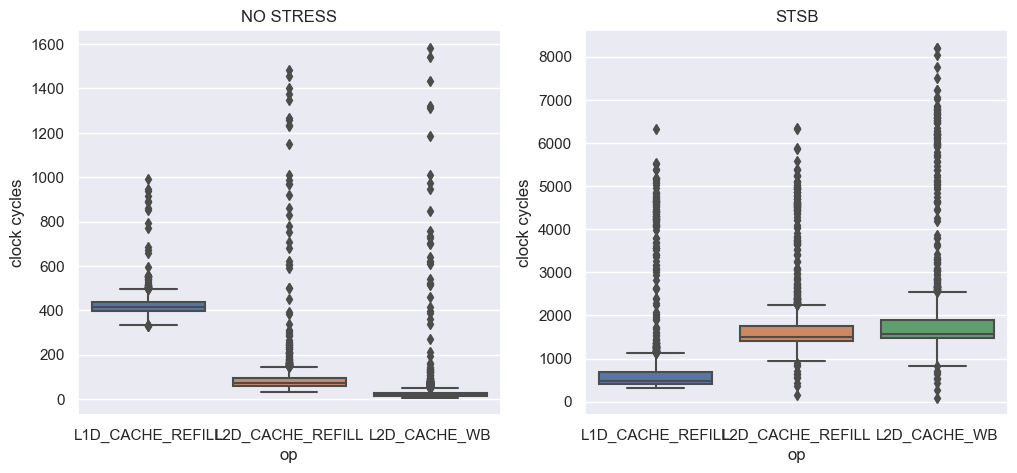

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
normal_df = test_df[test_df["CONTEXT"] == "NOSTRESS"]
stress_df = test_df[test_df["CONTEXT"] == ANOMALY_NAME]
sns.boxplot(x="variable", y="value", data=normal_df[predictors].melt(), ax=axs[0])
axs[0].set_title("NO STRESS")
axs[0].set_xlabel("op")
axs[0].set_ylabel("clock cycles")
sns.boxplot(x="variable", y="value", data=stress_df[predictors].melt(), ax=axs[1])
axs[1].set_xlabel("op")
axs[1].set_ylabel("clock cycles")
axs[1].set_title(ANOMALY_NAME)
plt.show()


In [18]:
test_fn(test_df, model)

Accuracy in regime prediction: 99.46%


In [19]:
import pickle

with open(f'models/{anomaly}.pkl', 'wb+') as f:
    pickle.dump({'headers': predictors, 'model': model}, f)